In [1]:
# Dependencies and Setup
import numpy as np
import pandas as pd
import pytz

import os 
from scipy import stats
import matplotlib.pyplot as plt
import re
import hvplot
import warnings
warnings.filterwarnings("ignore")
# Import citipy to determine the cities based on latitude and longitude
from citipy import citipy

In [3]:
# Load the CSV file located on BPD website into a Pandas DataFrame
arrest_data_df = pd.read_csv("Data/BPD_Arrests.csv")
# Display data
arrest_data_df.head()

,X,Y,arrestnumber,age,gender,race,arrestdatetime,arrestlocation,incidentoffence,incidentlocation,...,chargedescription,district,post,neighborhood,latitude,longitude,geolocation,incidentnumber,objectid,shape
0,1.401347e+06,608148.870493,23000037.0,39.0,M,B,2022/12/31 23:50:00+00,4000 OAKFORD ST,Unknown Offense,4000 OAKFORD ST,...,HGV,Northwest,621,West Arlington,39.3361,-76.6853,"(39.3361,-76.6853)",22L09338,1,NaN
1,1.401347e+06,608148.870493,23000039.0,50.0,M,B,2022/12/31 23:50:00+00,4000 OAKFORD ST,Unknown Offense,4000 OAKFORD ST,...,HGV,Northwest,621,West Arlington,39.3361,-76.6853,"(39.3361,-76.6853)",22L09338,2,NaN
2,NaN,NaN,23000010.0,27.0,M,B,2022/12/31 23:40:00+00,NaN,Unknown Offense,NaN,...,FAILURE TO APPEAR,NaN,NaN,NaN,NaN,NaN,"(,)",NaN,3,NaN
3,1.417636e+06,595206.835862,23000050.0,42.0,M,B,2022/12/31 23:15:00+00,500 DOLPHIN ST,Unknown Offense,500 DOLPHIN ST,...,HGV,Central,123,Upton,39.3004,-76.6279,"(39.3004,-76.6279)",22L09343,4,NaN
4,NaN,NaN,22157188.0,31.0,M,B,2022/12/31 21:00:00+00,NaN,Unknown Offense,NaN,...,FAILURE TO APPEAR,NaN,NaN,NaN,NaN,NaN,"(,)",NaN,5,NaN


In [4]:
# Define the desired time frame
start_date = pd.Timestamp("2018-01-01", tz="US/Eastern")
end_date = pd.Timestamp("2022-12-31", tz="US/Eastern")

# Convert date values to datetime format with EST timezone
arrest_data_df["arrestdatetime"] = pd.to_datetime(arrest_data_df["arrestdatetime"], utc=False)

# Filter the DataFrame based on the time frame
sample_arrests = (arrest_data_df["arrestdatetime"] >= start_date) & (arrest_data_df["arrestdatetime"] <= end_date)

# Apply the filter to get the narrowed down data
narrowed_data = arrest_data_df[sample_arrests]
narrowed_data



,X,Y,arrestnumber,age,gender,race,arrestdatetime,arrestlocation,incidentoffence,incidentlocation,...,chargedescription,district,post,neighborhood,latitude,longitude,geolocation,incidentnumber,objectid,shape
18,NaN,NaN,22157121.0,32.0,F,W,2022-12-31 03:53:00+00:00,NaN,Unknown Offense,NaN,...,FAILURE TO APPEAR,NaN,NaN,NaN,NaN,NaN,"(,)",NaN,19,NaN
19,1.432299e+06,594505.863803,22157116.0,19.0,M,B,2022-12-31 00:09:00+00:00,600 CURLY ST,Unknown Offense,600 CURLY ST,...,MOTOR VEHICLE THEFT,Southeast,224,Ellwood Park/Monument,39.2983,-76.5761,"(39.2983,-76.5761)",22L07944,20,NaN
20,1.407598e+06,592946.031158,22000022.0,18.0,M,B,2021-12-31 23:14:00+00:00,2800 EDMONDSON AVE,Unknown Offense,2800 EDMONDSON AVE,...,HGV,Western,721,Penrose/Fayette Street Outreach,39.2943,-76.6634,"(39.2943,-76.6634)",NaN,21,NaN
21,1.425747e+06,617095.607199,22000010.0,26.0,M,B,2021-12-31 22:09:00+00:00,5700 NORTHWOOD DR,Unknown Offense,5700 NORTHWOOD DR,...,HGV,Northern,523,Chinquapin Park,39.3604,-76.5989,"(39.3604,-76.5989)",NaN,22,NaN
22,NaN,NaN,21168317.0,24.0,M,B,2021-12-31 21:00:00+00:00,NaN,Unknown Offense,NaN,...,RAPE SECOND DEGREE,NaN,NaN,NaN,NaN,NaN,"(,)",NaN,23,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361706,1.427588e+06,603736.077990,18000078.0,23.0,F,B,2018-01-01 10:00:00+00:00,1600 E. 28TH ST,4ECOMMON ASSAULT,1600 E. 28TH ST,...,ASSAULT,Northeast,411,Coldstream Homestead Montebello,39.3237,-76.5926,"(39.3237,-76.5926)",18A00107,361707,NaN
361707,NaN,NaN,18000050.0,29.0,F,W,2018-01-01 09:45:00+00:00,NaN,Unknown Offense,NaN,...,CDS:POSSESS-NOT MARIJUANA,NaN,NaN,NaN,NaN,NaN,"(,)",NaN,361708,NaN
361708,1.432485e+06,603102.765099,18000045.0,46.0,M,B,2018-01-01 08:00:00+00:00,3200 HARWELL AVE,79OTHER,3200 HARWELL AVE,...,AGG. ASSAULT,Northeast,432,Belair-Edison,39.3219,-76.5753,"(39.3219,-76.5753)",18A00083,361709,NaN
361709,1.420414e+06,600936.840992,18000038.0,58.0,M,B,2018-01-01 05:30:00+00:00,2300 MARYLAND AVE,5DBURG. OTH. (FORCE),2300 MARYLAND AVE,...,COMMON ASSAULT,Northern,514,Old Goucher,39.3161,-76.6180,"(39.3161,-76.618)",18E00079,361710,NaN


In [ ]:
####Set Date Range and perform Temporal Analysis

In [5]:
# Convert `arrestdatetime` column to datetime if it's not already in that format
narrowed_data.loc["arrestdatetime"] = pd.to_datetime(narrowed_data["arrestdatetime"])

# Extract month and year components from the `arrestdatetime` column
narrowed_data["arrest_month"] = narrowed_data["arrestdatetime"].dt.month
narrowed_data["arrest_year"] = narrowed_data["arrestdatetime"].dt.year
pd.set_option('display.precision', 0)

# Group the data by month and year and count the number of arrests
arrest_counts = narrowed_data.groupby(["arrest_month", "arrest_year"]).size().reset_index(name="arrest_count")

# Print the resulting arrest counts
print(arrest_counts)


    arrest_month  arrest_year  arrest_count
0              1         2018          2036
1              1         2019          1733
2              1         2020          1577
3              1         2021           983
4              1         2022           920
5              2         2018          1725
6              2         2019          1607
7              2         2020          1502
8              2         2021           890
9              2         2022           885
10             3         2018          1849
11             3         2019          1812
12             3         2020          1298
13             3         2021          1048
14             3         2022           970
15             4         2018          1725
16             4         2019          2014
17             4         2020           820
18             4         2021           938
19             4         2022           944
20             5         2018          1715
21             5         2019   

Text(0, 0.5, 'Arrest Count')

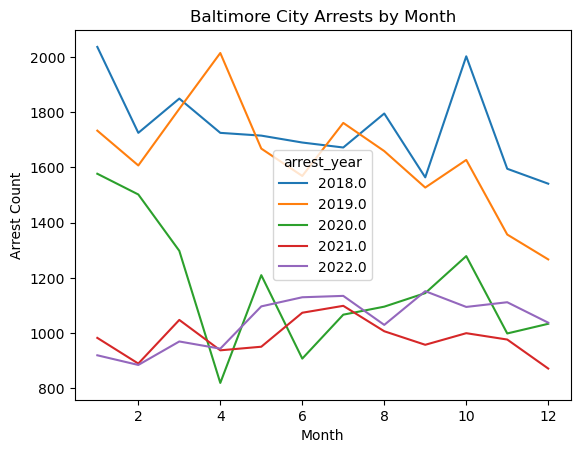

In [6]:
#Group month and year for 
arrest_counts_grouped = arrest_counts.groupby(['arrest_month', 'arrest_year']).sum().reset_index()

# Plot the grouped data
arrest_counts_grouped.pivot(index='arrest_month', columns='arrest_year', values='arrest_count').plot(kind='line')

#Assign labels and
plt.title("Baltimore City Arrests by Month")
plt.xlabel("Month")
plt.ylabel("Arrest Count")


In [7]:
# Group month and year into a single column for mapping
cols = ['arrest_month', 'arrest_year']
month_year = arrest_counts_grouped[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
pd.set_option('display.precision', 0)

# Name the column
month_year = month_year.rename('month_year')
# Print the data
month_year

0      1.0_2018.0
1      1.0_2019.0
2      1.0_2020.0
3      1.0_2021.0
4      1.0_2022.0
5      2.0_2018.0
6      2.0_2019.0
7      2.0_2020.0
8      2.0_2021.0
9      2.0_2022.0
10     3.0_2018.0
11     3.0_2019.0
12     3.0_2020.0
13     3.0_2021.0
14     3.0_2022.0
15     4.0_2018.0
16     4.0_2019.0
17     4.0_2020.0
18     4.0_2021.0
19     4.0_2022.0
20     5.0_2018.0
21     5.0_2019.0
22     5.0_2020.0
23     5.0_2021.0
24     5.0_2022.0
25     6.0_2018.0
26     6.0_2019.0
27     6.0_2020.0
28     6.0_2021.0
29     6.0_2022.0
30     7.0_2018.0
31     7.0_2019.0
32     7.0_2020.0
33     7.0_2021.0
34     7.0_2022.0
35     8.0_2018.0
36     8.0_2019.0
37     8.0_2020.0
38     8.0_2021.0
39     8.0_2022.0
40     9.0_2018.0
41     9.0_2019.0
42     9.0_2020.0
43     9.0_2021.0
44     9.0_2022.0
45    10.0_2018.0
46    10.0_2019.0
47    10.0_2020.0
48    10.0_2021.0
49    10.0_2022.0
50    11.0_2018.0
51    11.0_2019.0
52    11.0_2020.0
53    11.0_2021.0
54    11.0_2022.0
55    12.0

In [8]:
#Combine the two datasets to create one dataset with the newly combined 'month_year'
# Combine the two datasets to create one dataset with the newly combined 'month_year'
five_year = pd.concat([arrest_counts, month_year], axis=1)
five_year['arrest_year'] = pd.to_datetime(five_year['arrest_year'], format='%Y').dt.strftime('%Y')

# Sort the DataFrame by the 'arrest_year' column in descending order
five_year = five_year.sort_values(by='arrest_year', ascending=True)

# Display the sorted DataFrame
five_year

,arrest_month,arrest_year,arrest_count,month_year
0,1,2018,2036,1.0_2018.0
40,9,2018,1564,9.0_2018.0
20,5,2018,1715,5.0_2018.0
30,7,2018,1672,7.0_2018.0
15,4,2018,1725,4.0_2018.0
55,12,2018,1541,12.0_2018.0
25,6,2018,1690,6.0_2018.0
10,3,2018,1849,3.0_2018.0
50,11,2018,1595,11.0_2018.0
35,8,2018,1795,8.0_2018.0


In [9]:
# Combine the two datasets to create one dataset with the newly combined 'month_year'
five_year = pd.concat([arrest_counts, month_year], axis=1)
#five_year['arrest_year'] = pd.to_datetime(five_year['arrest_year'], format='%Y').dt.strftime('%Y')

# Sort the DataFrame by the 'arrest_year' and 'arrest_month' columns in descending order
five_year = five_year.sort_values(by=['arrest_year', 'arrest_month'], ascending=True)

# Display the sorted DataFrame
five_year


,arrest_month,arrest_year,arrest_count,month_year
0,1,2018,2036,1.0_2018.0
5,2,2018,1725,2.0_2018.0
10,3,2018,1849,3.0_2018.0
15,4,2018,1725,4.0_2018.0
20,5,2018,1715,5.0_2018.0
25,6,2018,1690,6.0_2018.0
30,7,2018,1672,7.0_2018.0
35,8,2018,1795,8.0_2018.0
40,9,2018,1564,9.0_2018.0
45,10,2018,2002,10.0_2018.0


Text(0, 0.5, 'Arrest Count')

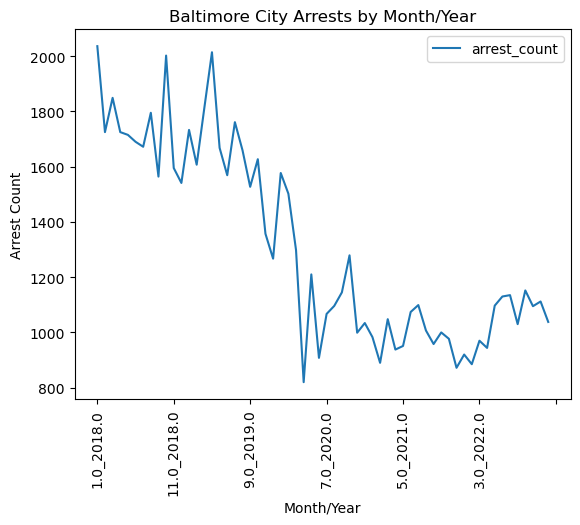

In [11]:
#Group month and year
#arrest_counts_grouped = arrest_counts.groupby(['arrest_month', 'arrest_year']).sum().reset_index()

# Plotting the grouped data
#five_year.pivot(index='month_year', columns='arrest_count').plot(kind='line')
# Plotting the grouped data
five_year.plot(x='month_year', y='arrest_count', kind='line', rot=90)

# Labeling
plt.title("Baltimore City Arrests by Month/Year")
plt.xlabel("Month/Year")
plt.ylabel("Arrest Count")


In [ ]:
####Review by Offense Type

In [ ]:
# Remove rows where 'chargedescription' is 'Unknown Charge'
narrowed_data = narrowed_data[narrowed_data['chargedescription'] != 'Unknown Charge']

# Display the updated DataFrame
narrowed_data


In [20]:
for index, row in narrowed_data.iterrows():
    print(f"{index} {row['chargedescription']}")
    br

18 FAILURE TO APPEAR


In [ ]:
x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)


In [19]:
indexes=narrowed_data['chargedescription'].value_counts().index

for index in indexes:
    if index 
     print(index)

FAILURE TO APPEAR
ASSAULT-SEC DEGREE
HGV
CDS
Unknown Charge
ASSAULT-FIRST DEGREE
COMMON ASSAULT
CDS VIOLATION
VIOLATION OF PROBATION
AGGRAVATED ASSAULT
ASSAULT
STOLEN AUTO
HANDGUN VIOLATION
ARMED ROBBERY
DETAIN ONLY
ROBBERY
AGG ASSAULT
ATT 1ST DEG. MURDER
2ND DEGREE ASSAULT
BURGLARY
PROSTITUTION
LARCENY
BURGLARY-FIRST DEGREE
VIOLATE EXPARTE/PROT ORDER
THEFT: $100 TO UNDER $1,500
CDS PWID
CDS DIST
CDS POSS
SECOND DEGREE ASSAULT
DESTRUCTION OF PROPERTY
FAIL REG OFFENDER/FALSE INFO
MURDER - FIRST DEGREE
THEFT
CDS DISTRIBUTION
UNARMED ROBBERY
AGG. ASSAULT
THEFT: $1,500 TO UNDER $25,000
CDS POSSESSION
TRESPASSING
1ST DEGREE ASSAULT
BURGLARY-THIRD DEGREE
BURGLARY- 4TH DEGREE-DWELL
MOTOR VEH/UNLAWFUL TAKING
CHILD ABUSE: 2ND DEG -CUST
BURGLARY/2ND DEGREE/GENERAL
THEFT LESS THAN $100.00
VIOLATE PROT ORDER
RAPE FIRST DEGREE
PWID
CDS: POSS W/I DIST: NARC
ARMED CARJACKING
HANDGUN ON PERSON
FAIL TO OBEY
ASSAULT 2ND DEGREE
VIOLATION OF PROTECTIVE ORDER
PEACE ORDER: FAIL TO COMPLY
HOME INVASION
ARSON

In [25]:
grouped_charges = narrowed_data.loc[:,['chargedescription', 'arrestdatetime']]
grouped_charges.loc[grouped_charges['chargedescription'].str.contains('assault', case=False, regex=True), 'chargedescription'] = 'Assault Charges'
grouped_charges.head()

KeyError: "None of [Index([False, False, False, False, False,  True, False, False, False, False,\n       ...\n       False, False, False, False,  True, False,  True,  True, False,   NaT],\n      dtype='object', length=78751)] are in the [index]"

In [12]:
#group together repetetive charge descriptions for cleaner data
# Copy the narrowed_data DataFrame
grouped_charges = narrowed_data.copy()

# Combine assault charge descriptions
#grouped_charges.loc[grouped_charges['chargedescription'].str.contains('assault', case=False), 'chargedescription'] = 'Assault Charges'

#grouped_charges['chargedescription'] = grouped_charges['chargedescription'].replace(str.contains(['assault', case=False)], 'Assault Charges')


#loc[grouped_charges['chargedescription'].str.contains('assault', case=False), 'chargedescription'] = 'Assault Charges'




# Combine narcotic descriptions




# Combine narcotic descriptions

# # Combine narcotic descriptions
grouped_charges.loc[grouped_charges['chargedescription'].str.contains('cds', case=False), 'chargedescription'] = 'Narcotic Charges'

# #combine all the handgun descriptions
# grouped_charges.loc[grouped_charges['chargedescription'].str.contains('HGV|handgun', case=False), 'chargedescription'] = 'Handgun Charges'

# #Combine all the robbery charge descriptions
# grouped_charges.loc[grouped_charges['chargedescription'].str.contains('robbery', case=False), 'chargedescription'] = 'Robbery Charges'

# #Combine all the larceny descriptions
# grouped_charges.loc[grouped_charges['chargedescription'].str.contains('larceny|theft', case=False), 'chargedescription'] = 'Larceny Charges'

# #Combine all the burglary charge descriptions
# grouped_charges.loc[grouped_charges['chargedescription'].str.contains('burglary', case=False), 'chargedescription'] = 'Burglary Charges'
grouped_charges

KeyError: "None of [Index([False, False, False, False, False, False, False, False, False, False,\n       ...\n       False, False, False, False, False,  True, False, False, False,   NaT],\n      dtype='object', length=78751)] are in the [index]"

In [ ]:
grouped_charges.to_csv("Data/grouped_charges2.csv")

In [ ]:
# Filter the top 10 charges for comparison based on charge description
top_10_charges = grouped_charges["chargedescription"].value_counts().nlargest(10).index
filtered_data = grouped_charges[grouped_charges["chargedescription"].isin(top_10_charges)]

# Print the filtered data
filtered_data

In [ ]:
# Group the data by month and year and count the number of arrests

charge_count = filtered_data.groupby(["arrest_year", "chargedescription"]).size().reset_index()

# Print the resulting DataFrame
charge_count

In [ ]:
#isolating top 3 charges for better graph readability
#df.loc[df['col1'].isin([value1, value2, value3, ...])]
top_3_charges=charge_count.loc[charge_count['chargedescription'].isin(['Assault Charges', 'Narcotic Charges', 'FAILURE TO APPEAR'])]
top_3_charges.head()

In [ ]:
top_3_charges.pivot(index='arrest_year', columns='chargedescription').plot(kind='line')

In [ ]:
#isolating lower charges for better graph readability
#df.loc[df['col1'].isin([value1, value2, value3, ...])]
bottom_7_charges=charge_count.loc[charge_count['chargedescription'].isin(['Assault Charges', 'Narcotic Charges', 'FAILURE TO APPEAR'])]
top_3_charges.head()

In [ ]:
# Plotting the grouped data


#charge_count.pivot(x='arrest_year', columns='chargedescription').plot(kind='line')
charge_count.pivot(index='arrest_year', columns='chargedescription').plot(kind='line')
#plt.plot(x_axis, charge_count, alpha=0.5)
#plt.title("Baltimore City Arrests by Charge Description and Year")
#plt.xlabel("Year")
#plt.ylabel("Arrests")
#plt.show()


In [ ]:
grouped_charges_all.to_csv("Data/grouped_charges.csv")